I need to figure out a way of translating the river mouth locations to the grid from the model. 

TOC:
1. read shapefiles (Lebreton or Meijer)
2. split Point objects.
3. bin the rivers into the coastal cells
4. Cluster the rivers in N groups
5. generate initial conditions for cluster
    - save the river coord inside the cluster
    - generate delayed realease randomized
    - save them, sneaky beasts
6. Compute priors.

In [9]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

In [2]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def rivers_per_location(DF, loc_coords, radius, binned=False):
    """
    Input
    - DF: the pandas Dataframe with data River_sources. 
    - loc_coords: tuple with the location coordinates as in (lat, lon).
    - radius: the radius in degrees around loc_coords.
    Returns 
    - the dataframe around loc_coords.
    """
    if binned:
        _label = '_bin'
        
    else:
        _label = ''
        
    x_col = f'X{_label}'
    y_col = f'Y{_label}'
    
    lat, lon = loc_coords
    mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
    new_DF = DF[mask]
    return new_DF, mask

def region_filters(DF, lon_min, lon_max, lat_min, lat_max, shapefile=False):
    """
    DF is the River_sources dataframes. lat_min, lat_max, lon_min, lon_max are the domain limits.
    Returns the dataframe only for the region.
    """
    if shapefile:
        X = DF.geometry.x
        Y = DF.geometry.y
    else:
        X = DF['X']
        Y = DF['Y']
        
    mask = (X <= lon_max) & (X > lon_min) & (Y <= lat_max) & (Y > lat_min)
    
    new_DF = DF[mask]
    return new_DF
    

In [3]:
coastal_fields = xr.load_dataset('../coastal_fields.nc')

In [4]:
coast = coastal_fields.coastal.values
lats = coastal_fields.lat.values
lons = coastal_fields.lon.values

X = coastal_fields.lon_mesh
Y = coastal_fields.lat_mesh

In [5]:
iy_coast, ix_coast = np.where(coast==1)
lat_coast = lats[iy_coast]
lon_coast = lons[ix_coast]

In [6]:
def nearest_coastal_cell(latidute, longitude, coord_lat, coord_lon):    
    """
    Function to find the index of the closest point to a certain lon/lat value.
    
    latidute and longitude are the dimensinal 1D arrays of the grid, with the same length.
    coord_lat and coord_lon are the coordinates of a point.
    """
    
    distance = np.sqrt((longitude-coord_lon)**2 + (latidute-coord_lat)**2)                     
    index = distance.argmin()               
        
    return index

In [7]:
nearest_coastal_cell(lat_coast, lon_coast, -10, -30)

4777

In [45]:
South_Atlantic_region = (-70, 25, -50, -5)

# 1. Loading data from GIS shapefiles

In [37]:
def convert_geopandas2pandas(geoDF):
    '''Replaces the geometry column with a X and Y columns
    There no built-in function for this in geopandas! 
    '''
    
    L = len(geoDF)
    coord = np.zeros((L,2))
    coord[:, 0] = geoDF.geometry.x
    coord[:, 1] = geoDF.geometry.y
    aux = pd.DataFrame(coord, columns=['X','Y'])
    geoDF.drop(columns=['geometry'], inplace=True)
    geoDF = pd.concat([geoDF, aux], axis=1)
    
    return geoDF

In [43]:
path = '../data/sources/Lebreton_rivers/PlasticRiverInputs/' 
lebreton = convert_geopandas2pandas(gpd.read_file(path))

In [46]:
lebreton.head()

,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,i_high_feb,i_mid_mar,...,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,X,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21753.3,22500000.0,9.812500,37.329167
1,0.117503,0.046447,0.431570,0.008847,0.003387,0.033584,0.025464,0.010425,0.089840,0.022978,...,0.172272,0.075899,0.067729,0.176044,0.588417,0.466081,506114.0,95100000.0,9.387500,37.254167
2,0.004653,0.001518,0.021067,0.000364,0.000116,0.001692,0.000750,0.000250,0.003305,0.000905,...,0.236187,0.135462,0.101813,0.223936,0.821796,0.500808,56294.6,33500000.0,9.804167,37.237500
3,0.163098,0.065719,0.586740,0.019418,0.007780,0.070142,0.041209,0.017347,0.141035,0.030320,...,0.275328,0.182635,0.184765,0.335541,1.101117,0.927117,349409.0,99200000.0,9.229167,37.220833
4,0.038200,0.014144,0.150693,0.003528,0.001281,0.014193,0.008848,0.003407,0.033372,0.007342,...,0.200378,0.105010,0.099647,0.219543,0.728243,0.591818,199000.0,39700000.0,9.254167,37.220833


In [47]:
path = '../data/sources/Meijer2021_midpoint_emissions/' 
meijer = convert_geopandas2pandas(gpd.read_file(path))

In [49]:
meijer.head()

,dots_exten,X,Y
0,0.164904,168.797917,-46.580833
1,0.124932,168.348750,-46.447083
2,1.213370,168.337083,-46.418750
3,0.121138,168.021250,-46.357917
4,0.197533,169.811250,-46.343750


# 2. 

In [82]:
def rivers2coastalgrid(DF, coastal_fields):
    
    N = len(DF)
    
    coast = coastal_fields.coastal.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    new_DF = pd.concat([DF, aux], axis=1)
    
    counts = new_DF.groupby(['X_bin', 'Y_bin']).count().loc[:, 'X'].values
    new_DF = new_DF.groupby(['X_bin', 'Y_bin']).sum()
    new_DF['merged_rivers'] = counts
    new_DF.reset_index(inplace=True)
    new_DF.drop(labels=['X', 'Y'], axis=1, inplace=True)

    return new_DF

We select a smaller region for the analysis.

In [83]:
sa_lebreton = region_filters(lebreton, *South_Atlantic_region)

In [84]:
bin_lebreton = rivers2coastalgrid(sa_lebreton, coastal_fields)

In [91]:
bin_lebreton.head()

,X_bin,Y_bin,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,...,runoff_jun,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,merged_rivers
0,-68.583336,-50.250000,0.006420,0.002029,0.030079,0.000594,0.000188,0.002776,0.000522,0.000165,...,1.429872,1.275802,1.136191,1.378335,1.437603,1.371964,1.351435,76543.190,4.542030e+10,4
1,-68.333336,-50.166668,0.000002,0.000000,0.000013,0.000000,0.000000,0.000001,0.000000,0.000000,...,0.413738,0.590872,0.562548,0.472751,0.317295,0.239723,0.223380,1564.809,5.068000e+08,3
2,-67.916664,-50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.240534,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,38.170,1.490000e+07,1
3,-67.833336,-49.916668,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.481065,0.561252,0.536468,0.516073,0.423039,0.340224,0.303836,251.043,9.570000e+07,2
4,-67.750000,-49.750000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.485726,0.584076,0.547501,0.512261,0.406353,0.322592,0.284390,403.819,1.475000e+08,2


In [86]:
sa_meijer = region_filters(meijer, *South_Atlantic_region)

In [87]:
bin_meijer = rivers2coastalgrid(sa_meijer, coastal_fields)

In [90]:
bin_meijer.head()

,X_bin,Y_bin,dots_exten,merged_rivers
0,-68.583336,-50.250000,0.342405,1
1,-67.583336,-49.250000,0.517043,1
2,-67.500000,-46.500000,0.446724,1
3,-67.500000,-45.916668,7.472280,1
4,-67.416664,-45.833332,5.246860,2


implement a counter for the rivers merged per bin

Text(0.5, 1.0, 'Lebreton')

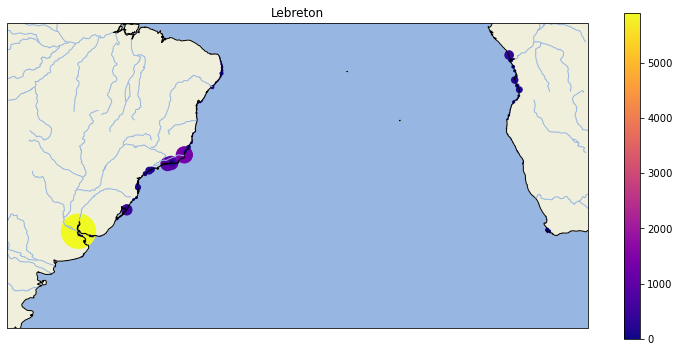

In [101]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(bin_lebreton['X_bin'], bin_lebreton['Y_bin'], c=bin_lebreton['i_high'],
                 s=bin_lebreton['i_high']/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Lebreton')

Text(0.5, 1.0, 'Meijer')

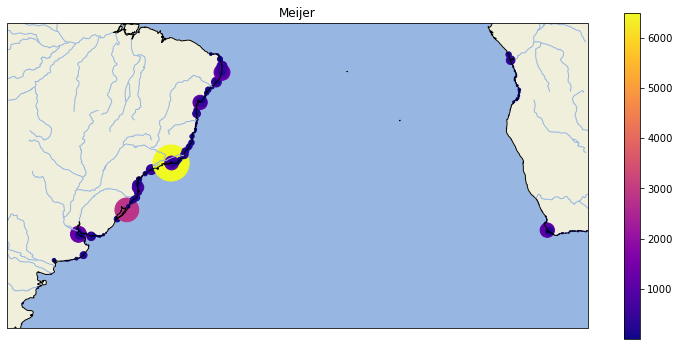

In [102]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(bin_meijer['X_bin'], bin_meijer['Y_bin'], c=bin_meijer['dots_exten'],
                 s=bin_meijer['dots_exten']/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Meijer')

# How to do the clustering? 

Three words: center of mass.

In [105]:
sort = bin_meijer.sort_values(['dots_exten'], ascending=False)

Text(0.5, 1.0, 'Meijer')

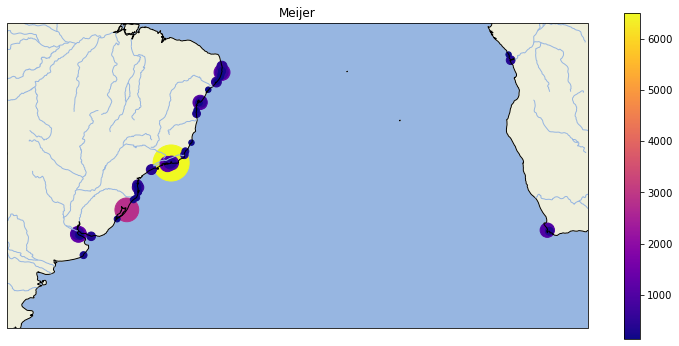

In [112]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

M = 50
#plt.pcolormesh(X, Y, coast)
im = plt.scatter(sort['X_bin'][:M], sort['Y_bin'][:M], c=sort['dots_exten'][:M],
                 s=sort['dots_exten'][:M]/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Meijer')

In [404]:
sorted_rivers

,X_bin,Y_bin,X,Y,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,...,runoff_may,runoff_jun,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area
208,-58.333332,-34.083332,-1636.558333,-941.141667,3055.897489,2174.494791,5911.251958,637.227565,466.058408,1193.394153,...,19.299130,4.608169,5.437723,3.726104,7.499207,8.283254,7.234376,12.517554,3.375835e+08,2.681950e+12
404,-41.000000,-21.583334,-41.037500,-21.620833,637.592368,426.756466,1319.697845,282.635241,197.222105,557.164060,...,0.563785,0.289560,0.226841,0.193345,0.294793,0.534659,1.659767,4.743814,2.566580e+07,5.735200e+10
381,-43.166668,-22.916666,-216.162500,-114.037500,399.469423,246.349487,907.042772,141.963414,90.917805,308.299556,...,4.376241,2.491326,2.794855,1.825627,3.639449,3.900097,10.819204,32.850995,2.400788e+07,1.379800e+09
377,-43.750000,-23.083334,-43.779167,-22.929167,420.592135,274.635938,894.433239,178.758176,121.472821,362.737768,...,0.592376,0.294719,0.409402,0.261267,0.561987,0.743999,1.696857,5.946026,1.681990e+07,2.073500e+09
306,-50.416668,-30.583334,-866.379167,-514.295833,219.042490,125.766972,536.224762,8.065385,4.365245,21.024644,...,6.229130,10.949088,22.047672,24.325310,27.020412,21.866450,20.456736,7.677155,3.927164e+07,8.413970e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,-65.333336,-44.416668,-195.912500,-133.287500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.507104,0.383943,0.413572,0.417366,0.422572,0.372775,0.297528,0.266829,1.065380e+02,1.405000e+08
24,-67.250000,-48.833332,-67.295833,-48.862500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.024775,0.021211,0.024588,0.024898,0.021681,0.022912,0.018668,0.026314,5.464300e+01,3.510000e+07
851,18.333334,-33.583332,36.725000,-67.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.604960e+04,5.730000e+07
850,18.333334,-34.083332,36.708333,-68.158333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.926186e+06,5.120000e+07


In [408]:
sorted_rivers['X_bin'][:100]

208   -58.333332
404   -41.000000
381   -43.166668
377   -43.750000
306   -50.416668
         ...    
390   -42.166668
468   -38.916668
336   -48.416668
219   -58.000000
293   -51.416668
Name: X_bin, Length: 100, dtype: float64

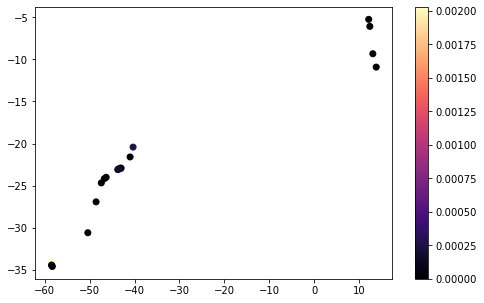

In [412]:
M = 20

plt.figure(figsize=(8,5))
im = plt.scatter(sorted_rivers['X_bin'][:M], sorted_rivers['Y_bin'][:M], c=group_bins['i_low'][:M],
                 cmap='magma', edgecolors=None)
plt.colorbar(im)

In [22]:
import geopandas as gpd

In [23]:
meijer = gpd.read_file('../data/sources/Meijer2021_midpoint_emissions/Meijer2021_midpoint_emissions.dbf')

In [42]:
sa_meijer = region_filters(meijer, *South_Atlantic_region, shapefile=True)
sa_meijer = pd.DataFrame({'discharge':sa_meijer['dots_exten'], 
                            'X':sa_meijer.geometry.x,
                            'Y':sa_meijer.geometry.y})

In [43]:
sa_meijer

,discharge,X,Y
19832,0.116729,19.713750,-34.762083
19833,1.843410,20.112917,-34.712083
19834,1.927560,19.412917,-34.604583
19835,0.600146,20.337083,-34.597083
19836,1.503210,20.447083,-34.506250
...,...,...,...
26370,1.130220,-36.735417,-5.087917
26371,0.311402,-35.761250,-5.087500
26372,0.191990,-35.880417,-5.067917
26373,0.512231,-35.861250,-5.067917


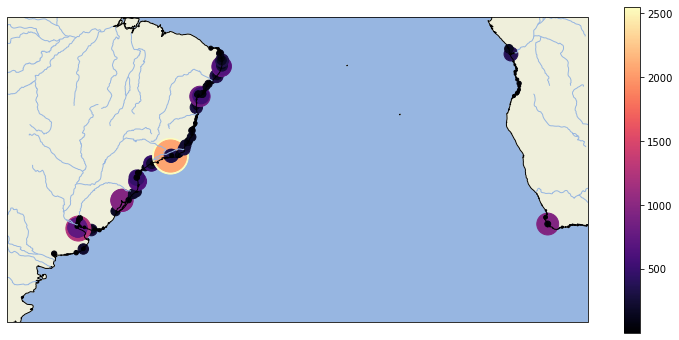

In [48]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
#plt.pcolormesh(X, Y, coast)
im = plt.scatter(sa_meijer['X'], sa_meijer['Y'], c=sa_meijer['discharge'],
                 s=sa_meijer['discharge']/2, cmap='magma', edgecolors=None)
plt.colorbar(im)

In [419]:
dbf = Dbf5('../data/sources/Meijer2021_midpoint_emissions/Meijer2021_midpoint_emissions.dbf')

In [420]:
dbf.to_dataframe()

,dots_exten
0,0.164904
1,0.124932
2,1.213370
3,0.121138
4,0.197533
...,...
31814,3.937440
31815,3.821710
31816,9.836130
31817,1.693040


In [400]:
group_bins

,X_bin,Y_bin,X,Y,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,...,runoff_may,runoff_jun,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area
0,-68.583336,-50.250000,-274.366667,-199.816667,0.006420,0.002029,0.030079,0.000594,0.000188,0.002776,...,1.784803,1.429872,1.275802,1.136191,1.378335,1.437603,1.371964,1.351435,76543.190,4.542030e+10
1,-68.333336,-50.166668,-205.604167,-149.779167,0.000002,0.000000,0.000013,0.000000,0.000000,0.000001,...,0.329205,0.413738,0.590872,0.562548,0.472751,0.317295,0.239723,0.223380,1564.809,5.068000e+08
2,-67.916664,-50.000000,-67.870833,-49.970833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.247040,0.240534,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,38.170,1.490000e+07
3,-67.833336,-49.916668,-135.616667,-99.808333,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.494086,0.481065,0.561252,0.536468,0.516073,0.423039,0.340224,0.303836,251.043,9.570000e+07
4,-67.750000,-49.750000,-135.450000,-99.491667,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,...,0.471913,0.485726,0.584076,0.547501,0.512261,0.406353,0.322592,0.284390,403.819,1.475000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,24.250000,-34.083332,24.245833,-34.079167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7406.500,2.060000e+07
908,24.416666,-34.083332,24.437500,-34.137500,0.000319,0.000088,0.001733,0.000018,0.000005,0.000103,...,0.053557,0.039968,0.038459,0.061292,0.058290,0.053420,0.052328,0.042955,90706.400,2.120000e+08
909,24.666666,-34.166668,24.629167,-34.170833,0.000165,0.000044,0.000935,0.000010,0.000002,0.000056,...,0.053558,0.039967,0.038460,0.061292,0.058290,0.053420,0.052328,0.042955,58853.500,9.950000e+07
910,24.833334,-34.083332,74.570833,-102.404167,0.000284,0.000077,0.001577,0.000014,0.000003,0.000079,...,0.058299,0.043860,0.045289,0.063106,0.045369,0.061789,0.063151,0.049192,162794.280,1.272300e+09


In [375]:
cluster_locations = {'Luanda':(-8.82, 13.22),
                     'Cuvo':(-10.87917, 13.81250),
                     'Chiloango-Congo':(-5.6442, 12.1375),
                     'Cape-Town':(-33.93, 18.56),
                    'Rio-de-la-Plata':(-33.9375, -58.5208),
                    'Porto-Alegre':(-30.051, -51.285),
                    'Santos':(-23.9875, -46.2958),
                    'Paraiba':(-21.6208, -41.0375),
                    'Itajai':(-26.9125, -48.6458),
                    'Rio-de-Janeiro':(-23.01250, -43.32083)}

In [ ]:
la

In [381]:
grid_cluster_centers = {}
for loc in cluster_locations:

    indx = nearest_coastal_cell(lat_coast, lon_coast, *cluster_locations[loc])
    grid_cluster_centers[loc] = (lat_coast[indx], lon_coast[indx])

In [382]:
grid_cluster_centers

{'Luanda': (-8.833333, 13.25),
 'Cuvo': (-10.916667, 13.833333),
 'Chiloango-Congo': (-5.6666665, 12.083333),
 'Cape-Town': (-33.916668, 18.416666),
 'Rio-de-la-Plata': (-34.083332, -58.333332),
 'Porto-Alegre': (-30.583334, -50.416668),
 'Santos': (-24.0, -46.333332),
 'Paraiba': (-21.583334, -41.0),
 'Itajai': (-26.916666, -48.583332),
 'Rio-de-Janeiro': (-23.0, -43.333332)}

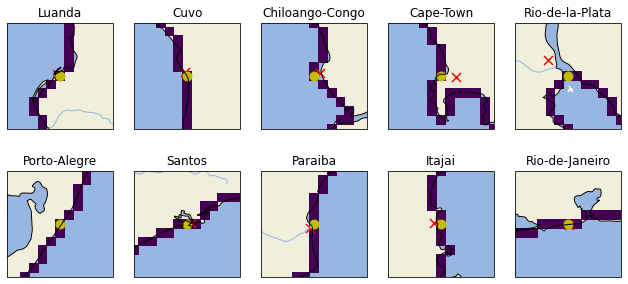

In [398]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(11,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})
r = 1/2
i = 0
coast_mask = np.ma.masked_equal(coast, 0)

ax = ax.reshape(10)
#smoc_field = smoc['uo'][0,0,indices['lat'], indices['lon']]
for k, loc in enumerate(cluster_locations):
    lat_BA, lon_BA = cluster_locations[loc]
    lat_bin, lon_bin = grid_cluster_centers[loc]
    ax[k].set_extent([lon_bin-r, lon_bin+r, lat_bin-r, lat_bin+r], crs=ccrs.PlateCarree())
    ax[k].add_feature(cfeature.OCEAN)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].add_feature(cfeature.RIVERS)
    ax[k].set_title(loc)
    ax[k].pcolormesh(X, Y, coast_mask)
    ax[k].scatter(lon_BA, lat_BA, s=80, marker='x', color='red')
    ax[k].scatter(lon_bin, lat_bin, s=80, marker='o', color='y') 


In [393]:
np.ma.masked_equal(coast, 0)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0)

# Overkill solution

In [329]:
def rivers2coastalgrid_2(DF, coastal_fields):
    
    N = len(DF)
    
    Bin_DF = pd.DataFrame()
    
    coast = coastal_fields.coastal.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    dx = np.diff(lons)[0]
    
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    DF = pd.concat([DF, aux], axis=1)
    
    L = len(lat_coast)
    
    for j in range(L):
        
        bin_mask = rivers_per_location(DF, (lat_coast[j], lon_coast[j]), dx/2, binned=True)
        
        if bin_mask.sum() > 0:
            series = DF[bin_mask].sum().to_frame()
            series
            Bin_DF = pd.concat([Bin_DF, series], axis=1)
            
    Bin_DF = Bin_DF.T
    Bin_DF = Bin_DF.reset_index()
    Bin_DF = Bin_DF.drop(['index', 'X', 'Y'], axis=1)
    
    return Bin_DF

In [330]:
binned_rivers = rivers2coastalgrid_2(SA_rivers, coastal_fields)

In [331]:
binned_rivers

,i_mid,i_low,i_high,i_mid_jan,i_low_jan,i_high_jan,i_mid_feb,i_low_feb,i_high_feb,i_mid_mar,...,runoff_jul,runoff_aug,runoff_sep,runoff_oct,runoff_nov,runoff_dec,mpw,area,X_bin,Y_bin
0,0.006420,0.002029,0.030079,0.000594,0.000188,0.002776,0.000522,0.000165,0.002436,0.000456,...,1.275802,1.136191,1.378335,1.437603,1.371964,1.351435,76543.190,4.542030e+10,-274.333344,-201.000000
1,0.000002,0.000000,0.000013,0.000000,0.000000,0.000001,0.000000,0.000000,0.000001,0.000000,...,0.590872,0.562548,0.472751,0.317295,0.239723,0.223380,1564.809,5.068000e+08,-205.000008,-150.500004
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.280626,0.268234,0.258034,0.211518,0.170115,0.151919,38.170,1.490000e+07,-67.916664,-50.000000
3,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.561252,0.536468,0.516073,0.423039,0.340224,0.303836,251.043,9.570000e+07,-135.666672,-99.833336
4,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.584076,0.547501,0.512261,0.406353,0.322592,0.284390,403.819,1.475000e+08,-135.500000,-99.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.007258,0.002439,0.031888,0.000136,0.000040,0.000684,0.000285,0.000089,0.001354,0.000898,...,3.812479,1.195510,0.737703,0.446491,0.317489,0.659113,27015.730,2.728000e+08,-73.666664,-10.000000
908,0.000318,0.000091,0.001658,0.000002,0.000001,0.000016,0.000007,0.000002,0.000042,0.000053,...,0.777333,0.383870,0.212927,0.144525,0.110292,0.111852,5643.460,6.930000e+07,-36.000000,-5.000000
909,0.003897,0.001296,0.017305,0.000022,0.000006,0.000122,0.000072,0.000021,0.000367,0.000648,...,0.570991,0.315397,0.182243,0.122829,0.093750,0.089655,33336.900,2.591000e+08,-35.916668,-5.000000
910,0.002454,0.000795,0.011214,0.000014,0.000004,0.000078,0.000044,0.000012,0.000231,0.000394,...,0.537426,0.295928,0.171681,0.116195,0.088978,0.084943,25921.600,1.856000e+08,-35.833332,-5.000000


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


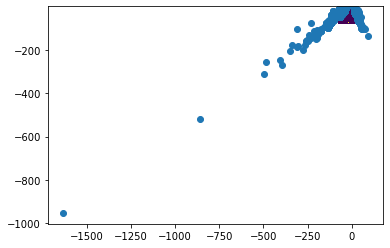

In [333]:
plt.pcolormesh(X, Y, coast)
plt.scatter(binned_rivers['X_bin'], binned_rivers['Y_bin'])

Overkill and wrong :sad: